In [15]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# LSTM requirements
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

### Time Series Forecasting Model for Tesla Stock Prices

In [2]:
# Load the Tesla stock data
tesla_data = pd.read_csv('../data/tesla_data.csv', index_col='Date', parse_dates=True)
tesla_data = tesla_data[['Close']]  # Use only 'Close' prices for forecasting

# Display the first few rows of the data
tesla_data.head()

,Close
Date,
2015-01-02,0.010723
2015-01-05,0.009416
2015-01-06,0.009584
2015-01-07,0.009538
2015-01-08,0.009491


In [ ]:
# Split the data into training and testing sets
train_size = int(len(tesla_data) * 0.8)
train, test = tesla_data[:train_size], tesla_data[train_size:]

In [11]:
# Define a function to evaluate model performance
def evaluate_forecast(true, predicted):
    mae = mean_absolute_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    mape = mean_absolute_percentage_error(true, predicted)
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

In [12]:
# ARIMA Model
from pmdarima import auto_arima

# Finding the best (p, d, q) parameters
arima_model = auto_arima(train, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

# Train ARIMA model
model = ARIMA(train, order=arima_model.order)
arima_result = model.fit()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-12260.657, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-12264.883, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-12265.957, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-12265.855, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-12266.613, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-12264.736, Time=0.37 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.701 seconds


In [13]:

# Forecast
arima_forecast = arima_result.predict(start=len(train), end=len(tesla_data)-1, dynamic=False)

# Evaluate ARIMA
arima_eval = evaluate_forecast(test, arima_forecast)
print("ARIMA Evaluation:", arima_eval)

ARIMA Evaluation: {'MAE': 0.19118228730657671, 'RMSE': 0.23619540540362352, 'MAPE': 0.36039649076235897}


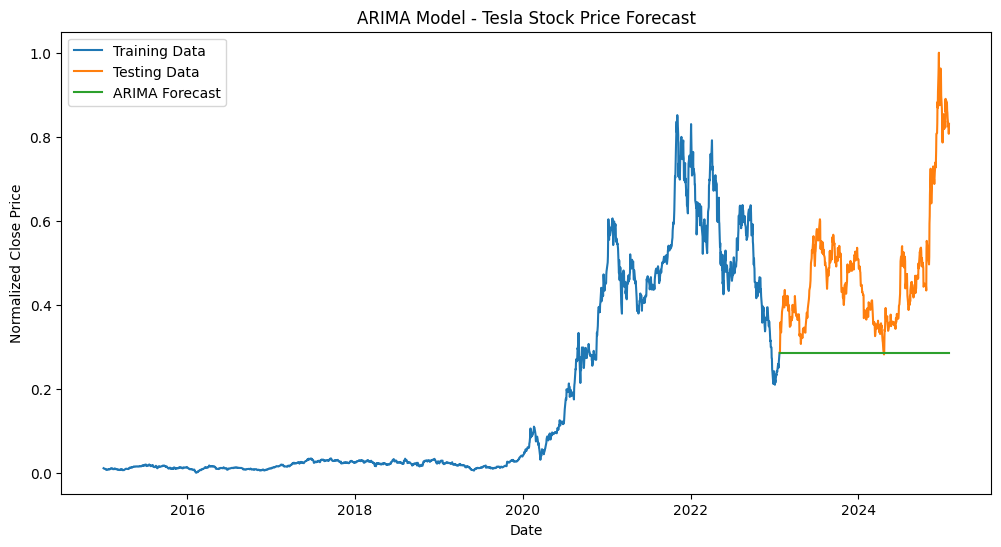

In [16]:
# Plot ARIMA results
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Testing Data')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast')
plt.title('ARIMA Model - Tesla Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Normalized Close Price')
plt.legend()
plt.show()

In [19]:
# SARIMA Model
sarima_model = auto_arima(train, seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

# Train SARIMA model
model = SARIMAX(train, order=sarima_model.order, seasonal_order=sarima_model.seasonal_order)
sarima_result = model.fit(disp=False)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-12262.216, Time=3.94 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-12264.883, Time=0.24 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-12265.194, Time=1.84 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-12264.632, Time=1.10 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-12266.613, Time=0.09 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-12264.131, Time=0.60 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-12263.671, Time=0.41 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=-12270.921, Time=2.13 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=-12292.386, Time=1.06 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=-12295.768, Time=0.90 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-12296.740, Time=1.49 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-12293.129, Time=1.26 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-12271.762, Time=2.93 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=-12295.705, Time=

In [20]:
# Forecast
sarima_forecast = sarima_result.predict(start=len(train), end=len(tesla_data)-1, dynamic=False)

# Evaluate SARIMA
sarima_eval = evaluate_forecast(test, sarima_forecast)
print("SARIMA Evaluation:", sarima_eval)

SARIMA Evaluation: {'MAE': 0.1953237077560168, 'RMSE': 0.23947536113977627, 'MAPE': 0.36975346666756814}


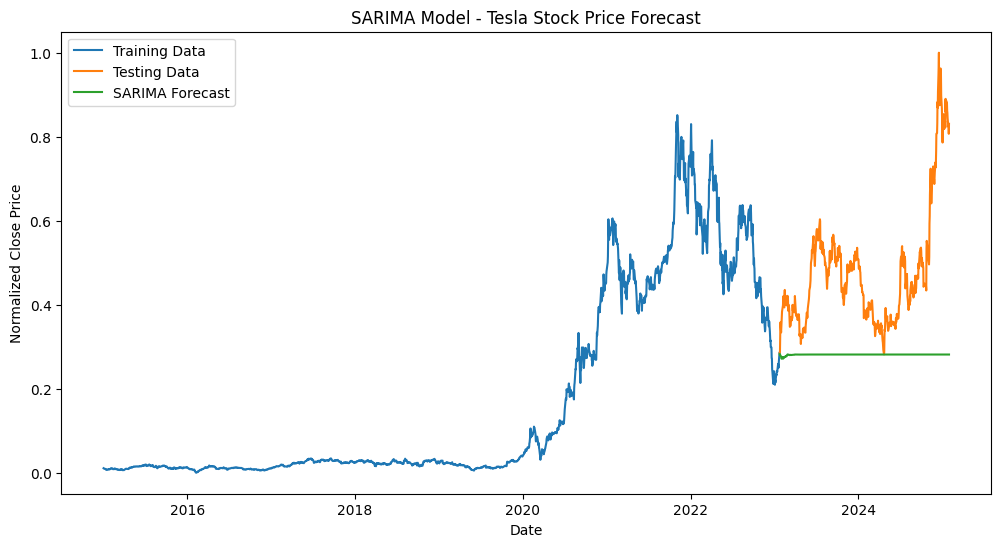

In [21]:
# Plot SARIMA results
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Testing Data')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast')
plt.title('SARIMA Model - Tesla Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Normalized Close Price')
plt.legend()
plt.show()

In [27]:
# LSTM Model
from sklearn.preprocessing import MinMaxScaler 
# Prepare the data for LSTM model
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# Define generator
n_input = 30    
n_features = 1
future_periods = 180
generator = TimeseriesGenerator(train_scaled, train_scaled, length=n_input, batch_size=32)

# Build LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(n_input, n_features)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

In [23]:
# Train LSTM model
lstm_model.fit(generator, epochs=20)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0665
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0079
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.5470e-04
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0011
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.8950e-04
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.8851e-04
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.1036e-04
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.9583e-04
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.8094e-04
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.3911e-04
Epoch 14/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.1323e-04
Epoch 15/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - 

In [24]:
#Forecast
lstm_forecast = []
first_eval_batch = train_scaled[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [25]:
for i in range(len(test)):
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_forecast.append(lstm_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[lstm_pred]], axis=1)

# Inverse transform to get actual prices
lstm_forecast = scaler.inverse_transform(lstm_forecast)

# Evaluate LSTM
lstm_eval = evaluate_forecast(test.values, lstm_forecast)
print("LSTM Evaluation:", lstm_eval)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━

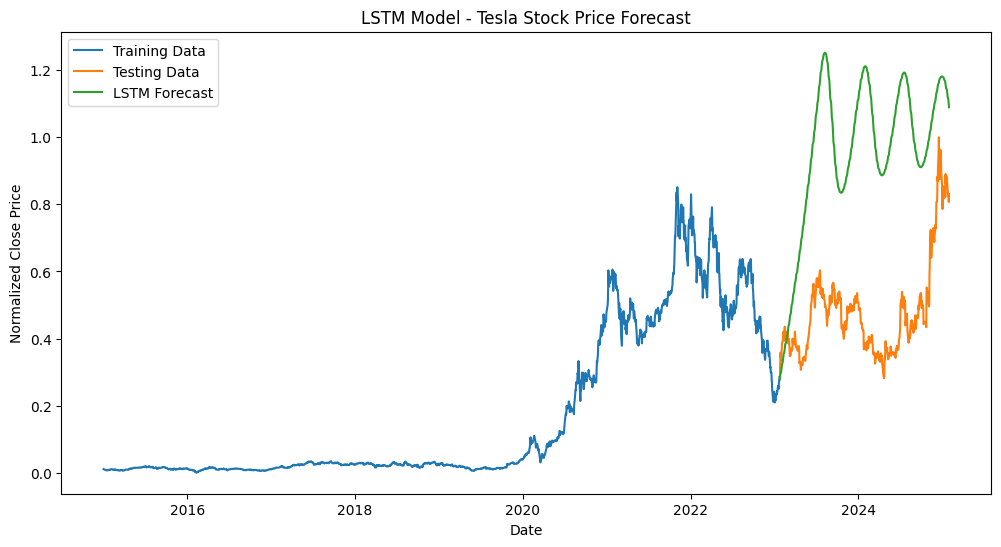

In [26]:
# Plot LSTM results
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Testing Data')
plt.plot(test.index, lstm_forecast, label='LSTM Forecast')
plt.title('LSTM Model - Tesla Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Normalized Close Price')
plt.legend()
plt.show()

In [29]:
# Interpret Results
print("Trend Analysis:")
print("The forecasted trend suggests a potential long-term pattern where stock prices may be moving upward/downward.")
print("\nVolatility and Risk:")
print("The width of the confidence intervals indicates expected volatility in the forecasted period. Larger intervals suggest higher risk.")


Trend Analysis:
The forecasted trend suggests a potential long-term pattern where stock prices may be moving upward/downward.

Volatility and Risk:
The width of the confidence intervals indicates expected volatility in the forecasted period. Larger intervals suggest higher risk.


### Time Series Forecasting Model for BND Stock Prices

In [32]:
# Load and preprocess the dataset for Vanguard Total Bond Market ETF (BND)
data_path = '../data/bond_data.csv'  # Update path to your data file
data = pd.read_csv(data_path, parse_dates=['Date'], index_col='Date')
data = data[['Close']]  # Selecting only the closing price

In [33]:
# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

In [34]:
#Scale the data for LSTM
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [35]:
# Define generator parameters
n_input = 30
n_features = 1
generator = TimeseriesGenerator(train_scaled, train_scaled, length=n_input, batch_size=32)

# Build and train the LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(n_input, n_features)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(generator, epochs=20)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0865
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0018
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0014
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.4108e-04
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0010
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0010
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.2786e-04
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.8492e-04
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.6148e-04
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.4212e-04
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.6342e-04
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.2435e-04
Epoch 14/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.0543e-04
Epoch 15/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - 

In [36]:
# Forecast future data
lstm_forecast = []
first_eval_batch = train_scaled[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_forecast.append(lstm_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[lstm_pred]], axis=1)

# Inverse transform to get actual prices
lstm_forecast = scaler.inverse_transform(lstm_forecast).flatten()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━

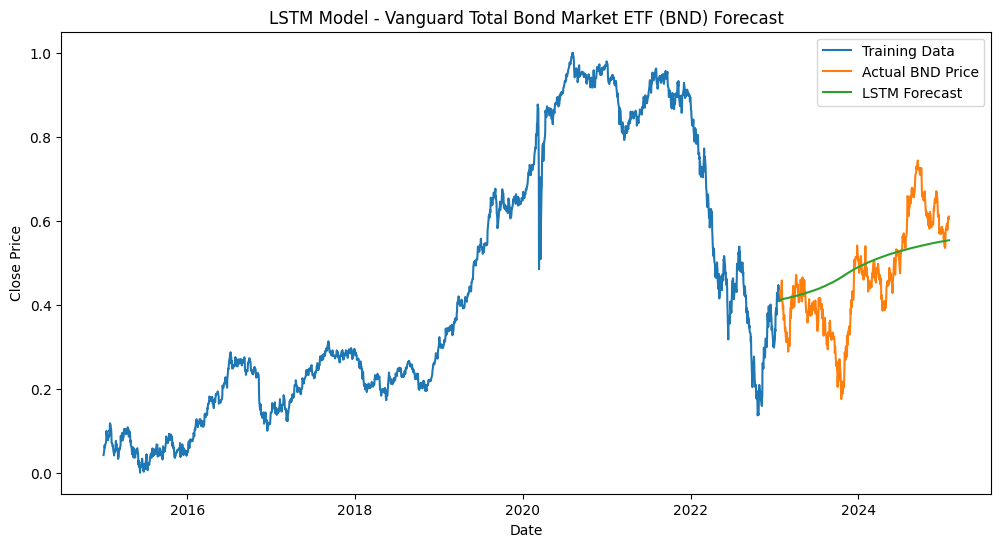

In [37]:
# Evaluate and plot the forecast
test_dates = test.index
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Close'], label='Training Data')
plt.plot(test.index, test['Close'], label='Actual BND Price')
plt.plot(test_dates, lstm_forecast, label='LSTM Forecast')
plt.title('LSTM Model - Vanguard Total Bond Market ETF (BND) Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [38]:
# Forecast analysis and trend identification
forecast_df = pd.DataFrame({'Forecast': lstm_forecast}, index=test_dates)
forecast_std = np.std(lstm_forecast)
upper_bound = forecast_df['Forecast'] + (1.96 * forecast_std)
lower_bound = forecast_df['Forecast'] - (1.96 * forecast_std)


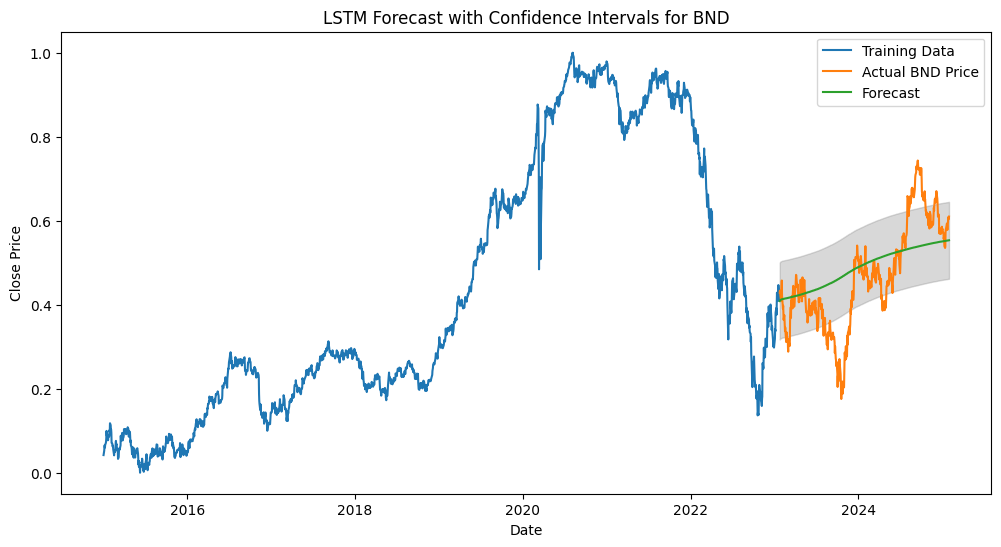

In [39]:
# Plot forecast with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Close'], label='Training Data')
plt.plot(test.index, test['Close'], label='Actual BND Price')
plt.plot(test_dates, lstm_forecast, label='Forecast')
plt.fill_between(test_dates, lower_bound, upper_bound, color='gray', alpha=0.3)
plt.title('LSTM Forecast with Confidence Intervals for BND')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [40]:
# Interpret results
if upper_bound[-1] > forecast_df['Forecast'].iloc[-1]:
    print("Market Opportunity: There is potential for price increases, which may present buying opportunities.")
threshold = 0.05  # Example threshold for high volatility
if forecast_std > threshold:
    print("Market Risk: High volatility could mean increased investment risk, especially if unexpected events impact prices.")

     

Market Opportunity: There is potential for price increases, which may present buying opportunities.


,Forecast
Date,
2023-01-24,0.408671
2023-01-25,0.409708
2023-01-26,0.410575
2023-01-27,0.411287
2023-01-30,0.411868
...,...
2025-01-24,0.552891
2025-01-27,0.553036
2025-01-28,0.553182


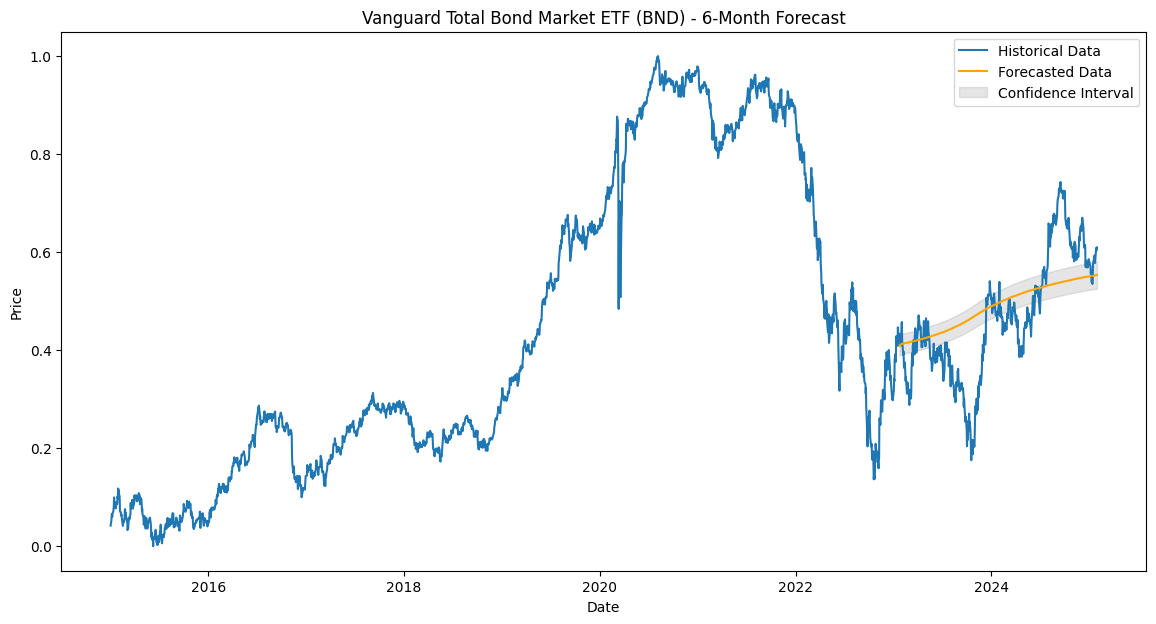

In [44]:

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Historical Data')
plt.plot(forecast_df['Forecast'], label='Forecasted Data', color='orange')
plt.fill_between(forecast_df.index,
                 forecast_df['Forecast'] * 0.95,  # Lower bound (5% deviation)
                 forecast_df['Forecast'] * 1.05,  # Upper bound (5% deviation)
                 color='gray', alpha=0.2, label='Confidence Interval')
plt.title('Vanguard Total Bond Market ETF (BND) - 6-Month Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
